<a href="https://colab.research.google.com/github/KelvinM9187/FeedForwardNeuralNetwork/blob/main/FeedForwardNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kelvinmhodizukuku","key":"755e5663cff12b515c856ae2097d87fc"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mengcius/cinic10

Dataset URL: https://www.kaggle.com/datasets/mengcius/cinic10
License(s): unknown
100% 751M/754M [00:03<00:00, 172MB/s]
100% 754M/754M [00:03<00:00, 198MB/s]


In [ ]:
!unzip cinic10.zip -d cinic10

Streaming output truncated to the last 5000 lines.
  inflating: cinic10/valid/truck/n03632852_1173.png  
  inflating: cinic10/valid/truck/n03632852_11766.png  
  inflating: cinic10/valid/truck/n03632852_11887.png  
  inflating: cinic10/valid/truck/n03632852_1191.png  
  inflating: cinic10/valid/truck/n03632852_1192.png  
  inflating: cinic10/valid/truck/n03632852_1195.png  
  inflating: cinic10/valid/truck/n03632852_1207.png  
  inflating: cinic10/valid/truck/n03632852_12128.png  
  inflating: cinic10/valid/truck/n03632852_1214.png  
  inflating: cinic10/valid/truck/n03632852_1237.png  
  inflating: cinic10/valid/truck/n03632852_1248.png  
  inflating: cinic10/valid/truck/n03632852_1261.png  
  inflating: cinic10/valid/truck/n03632852_1264.png  
  inflating: cinic10/valid/truck/n03632852_1292.png  
  inflating: cinic10/valid/truck/n03632852_1313.png  
  inflating: cinic10/valid/truck/n03632852_1319.png  
  inflating: cinic10/valid/truck/n03632852_13311.png  
  inflating: cinic10/valid/

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# feed forward neural network
class FeedForwardNet(nn.Module):
    def __init__(self, input_size=3072, hidden1=1024, hidden2=512, num_classes=10):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.dropout1 = nn.Dropout(0.5)   # 50% dropout
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
def train_feedforward(epochs=50, batch_size=128, lr=0.01, momentum=0.9):
    # Data augmentation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # CINIC-10 dataset
    train_data = torchvision.datasets.ImageFolder("cinic10/train", transform=transform_train)
    val_data   = torchvision.datasets.ImageFolder("cinic10/valid", transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Model, loss, optimizer
    model = FeedForwardNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # halve LR every 10 epochs

    # Tracking
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # flatten [B, 3, 32, 32] -> [B, 3072]
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct / total

        # Save stats
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        scheduler.step()

    # Visualization
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs, label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy over Epochs")
    plt.legend()

    plt.show()

    return model


Epoch [1/50] Train Loss: 2.0413 | Train Acc: 24.14% | Val Loss: 1.9280 | Val Acc: 29.35%
Epoch [2/50] Train Loss: 1.9357 | Train Acc: 28.89% | Val Loss: 1.8602 | Val Acc: 31.72%
Epoch [3/50] Train Loss: 1.9076 | Train Acc: 29.91% | Val Loss: 1.8116 | Val Acc: 33.47%
Epoch [4/50] Train Loss: 1.8829 | Train Acc: 31.07% | Val Loss: 1.8090 | Val Acc: 34.05%
Epoch [5/50] Train Loss: 1.8588 | Train Acc: 31.84% | Val Loss: 1.7924 | Val Acc: 34.06%
Epoch [6/50] Train Loss: 1.8401 | Train Acc: 32.63% | Val Loss: 1.7559 | Val Acc: 36.58%
Epoch [7/50] Train Loss: 1.8274 | Train Acc: 33.15% | Val Loss: 1.7384 | Val Acc: 36.55%
Epoch [8/50] Train Loss: 1.8132 | Train Acc: 33.65% | Val Loss: 1.7377 | Val Acc: 36.19%
Epoch [9/50] Train Loss: 1.8037 | Train Acc: 34.01% | Val Loss: 1.7508 | Val Acc: 36.53%
Epoch [10/50] Train Loss: 1.7991 | Train Acc: 34.40% | Val Loss: 1.7479 | Val Acc: 36.35%
Epoch [11/50] Train Loss: 1.7563 | Train Acc: 35.77% | Val Loss: 1.6918 | Val Acc: 38.90%
Epoch [12/50] Train

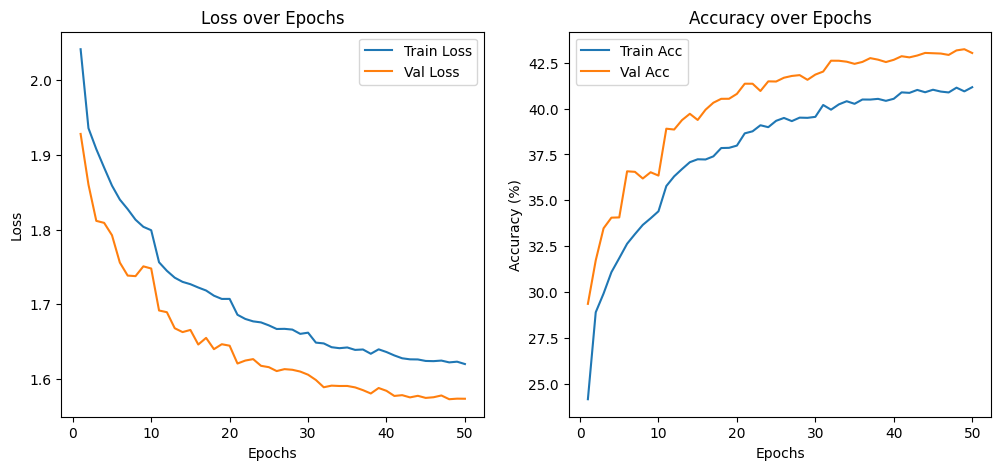

In [ ]:
if __name__ == "__main__":
    train_feedforward(epochs=50)